<center> <h1>PRIMERA PREDICIÓN DEL SUEÑO DE UN PACIENTE</h1> </center>
<center> <h4>Noemi González, Roberto Holgado y Carmen Plaza seco</h4> </center>

[URL PHYSIONET](https://physionet.org/content/sleep-accel/1.0.0/)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import statistics as stats

In [2]:
pacientes_sueño=[]
for file in (os.listdir("labels")):
    pacientes_sueño.append(os.path.join("labels",file))
    pacientes_sueño=sorted(pacientes_sueño)
    
pacientes_frec_card=[]
for file in os.listdir("heart_rate"):
    pacientes_frec_card.append(os.path.join("heart_rate",file))

pacientes_pasos=[]
for file in os.listdir("steps"):
    pacientes_pasos.append(os.path.join("steps",file))

pacientes_movimiento=[]
for file in os.listdir("motion"):
    pacientes_movimiento.append(os.path.join("motion",file))

La siguiente celda de código se corresponde con la ventana deslizante que recorrerá la señal fisiológica deseada. La función toma como datos de entrada el tamaño de la ventana en segundos y la señal sobre la que se quiere trabajar.

In [3]:
def get_window(w_size,signal,n_sueño):
    time = signal["Tiempo"]
    f_list=[]
    
    for i in range(n_sueño):
        a = w_size*(1+i)
        b = w_size*(2+i)

        idx=[]
        for t in time:
            if t>a and t<b:
                idx.append(True)
            else:
                idx.append(False)
        
        f=signal[idx]
        f_list.append(f)
        
    return f_list

En todos los casos, se seleccionará una w_size de 30 segundos para tener una característica cada 30s y así coincidir la cantidad de los datos adquiridos por medio del Apple Watch con los datos recogidos por la PSG.

Con la señal de frecuencia cardíaca se han decidido sacar 3 vectores de características: mínimo, máximo y media.

## FEATURES

* **feat1: min_list**. La primera característica que se extrae es la lista de frecuencias mínimas.
* **feat2: max_list**. La segunda característica que se extrae es la lista de frecuencias máximas.
* **feat3: mean_list**. La tercera característica que se extrae es la lista de frecuencias medias.

## OUTCOME

* **labels:**. Lista de etiquetas del sueño

# IDENTIFICACION
* **ID:**. Variable que identifica a cada paciente.

# MATRICES HIJAS

Realizamos esta operación sobre todos los pacientes

In [4]:
matrices_hija=[]
for a, (i,j) in  enumerate(zip(pacientes_sueño,pacientes_frec_card)):
    #SUEÑO
    sueño=pd.read_csv(i, delimiter=' ')
    sueño.columns=["Tiempo","Etiqueta"]

    #FRECUENCIA CARDIACA
    frec_card=pd.read_csv(j)
    frec_card.columns=["Tiempo","Frec card"]
    
    w_size=30
    signal=frec_card
    n_sueño=len(sueño)
    f_list= get_window(w_size,signal,n_sueño)

    mean_list=[]
    min_list=[]
    max_list=[]

    for f in f_list:
        mean_list.append(round(f['Frec card'].mean(),2))
        min_list.append(round(f['Frec card'].min(),2))
        max_list.append(round(f['Frec card'].max(),2))
    
    feat1=min_list
    feat2=max_list
    feat3=mean_list
    labels=sueño["Etiqueta"]
    id_list=[a]*len(labels)
    
    datos = {'Min_hr': feat1, "Max_hr": feat2,"Mean_hr":feat3,"Etiquetas":labels,"ID_P":id_list}
    datos_paciente = pd.DataFrame(data=datos)
    matrices_hija.append(datos_paciente) #matrices_hija=matriz_madre, están todas las hijas en esta variable

En la variable matrices_hija tenemos las matrices de características de cada paciente. Es decir, matrices_hija es la matriz_madre.

In [ ]:
# Separar el for en los núcleos 
# client.MultiEngineClient.map()

Esto es una funcion para limpiar el dataframe de Nan y valores inf en caso de que fuera necesario.

In [8]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

# MODELO PARA PRIMERA VENTANA

Para construir un clasificador SVM, al meter todas las ventanas de todos los pacientes tenemos una salida multiclase, (y esto no nos lo predice bien, predice una salida biclase). 

Por ello, a continuación vamos a concatenar la primera ventana de cada paciente. Las primeras ventanas (30s) del 70% de los pacientes las utilizaremos para entrenar un clasificador SVM y vamos a predecir las primeras ventanas del 30% de los pacientes. 



In [177]:
# Quiero concatenar los primeros 30s de todos los pacientes
primera_ventana=pd.DataFrame()
for i in range(len(matrices_hija)):
    ven1=matrices_hija[i].iloc[0,:]
    primera_ventana=primera_ventana.append(ven1)

In [178]:
# Train y Test. Train: 70%, Test: 30%
train, test = train_test_split(primera_ventana, test_size = 0.30)

In [184]:
#TRAIN
#Training= clean_dataset(train) 
X_train=train.iloc[:,2:5]
y_train=train["Etiquetas"]

#TEST
#Test=clean_dataset(Test)            
X_test=test.iloc[:,2:5]
y_test=test["Etiquetas"]

# Creación modelo y evaluación

In [185]:
#CREACION
svc_clf = SVC(C=10**5, kernel='rbf',gamma=0.0001,decision_function_shape='ovo')
svc_clf.fit(X_train, y_train)

SVC(C=100000, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [186]:
svc_clf.classes_

array([-1.,  0.])

In [187]:
predict = svc_clf.predict(X_test)
#EVALUACION

acc_test= svc_clf.score(X_test, y_test).round(4)
acc_train= svc_clf.score(X_train, y_train).round(4)
print('La exactitud para el modelo de SVM en el conjunto de TEST es:',acc_test,'\n')
print('La exactitud para el modelo de SVM en el conjunto de TRAIN es:',acc_train,'\n')

print('Confusion Matrix')
print(confusion_matrix(y_test, predict),'\n')
#print("=============== Classification Report ================")
#print(classification_report(y_test, predict))

La exactitud para el modelo de SVM en el conjunto de TEST es: 0.5 

La exactitud para el modelo de SVM en el conjunto de TRAIN es: 0.8095 

Confusion Matrix
[[4 1]
 [4 1]] 



In [194]:
matriz_confusion=pd.crosstab(y_test,predict, rownames=['Clase predicha'], colnames=['Resultado del clasificador'])

In [195]:
matriz_confusion

Resultado del clasificador,-1.0,0.0
Clase predicha,,
-1.0,4,1
0.0,4,1


# Residuos

In [190]:
y_test

0    0.0
0    0.0
0   -1.0
0   -1.0
0   -1.0
0    0.0
0   -1.0
0   -1.0
0    0.0
0    0.0
Name: Etiquetas, dtype: float64

In [191]:
predict

array([-1.,  0.,  0., -1., -1., -1., -1., -1., -1., -1.])

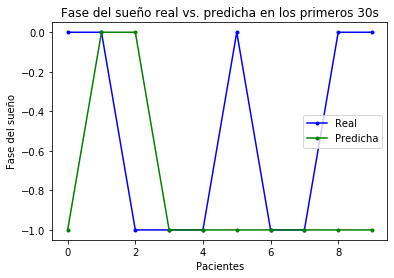

In [210]:
pacientes = len(y_test)
eje = np.arange(0,pacientes)
plt.figure()
plt.plot(t,y_test,color='blue', marker='.',label='Real')
plt.plot(t,predict,color='green', marker='.',label='Predicha')
plt.xlabel('Pacientes')
plt.ylabel('Fase del sueño')
plt.title('Fase del sueño real vs. predicha en los primeros 30s')
plt.legend()

Text(0.5, 1.0, 'Residuo primera ventana')

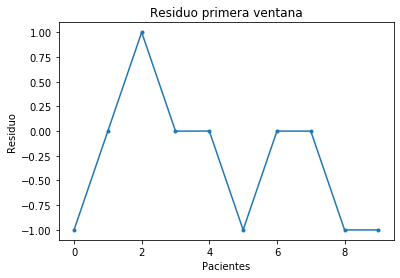

In [215]:
residuo=predict-y_test
plt.figure()
plt.plot(t,residuo,marker='.')
plt.xlabel('Pacientes')
plt.ylabel('Residuo')
plt.title('Residuo primera ventana')


# MODELO 'X' O TODAS VENTANAS

La siguiente celda concatena las X ventanas que queramos de todos los pacientes. El **problema** está en que al separar train y test con mas de una ventana, se nos mezclan las ventanas de un mismo paciente en train y test. Es decir, al hacer la partición puede quedar la primera ventana de un paciente en train y la segunda de este mismo paciente en test (habría que utilizar el ID para separar pero no se como hacerlo).

In [216]:
# Quiero concatenar los primeros X segundos de todos los pacientes
ventanas=pd.DataFrame()
for i in range(len(matrices_hija)):
    ven=matrices_hija[i].iloc[0:2,:] # Dos primeras ventanas de cada paciente
    ventanas=ventanas.append(ven)

In [217]:
ventanas

,Min_hr,Max_hr,Mean_hr,Etiquetas,ID_P
0,74.0,75.0,74.43,0,0
1,64.0,73.0,68.17,0,0
0,79.0,86.0,81.17,-1,1
1,81.0,82.0,81.83,-1,1
0,73.0,77.0,75.00,-1,2
...,...,...,...,...,...
1,60.0,61.0,60.40,-1,28
0,62.0,65.0,63.20,0,29
1,64.0,69.0,66.50,0,29
0,68.0,73.0,70.33,0,30


¡¡¡PROBLEMA!!!

In [222]:
# Train y Test. Train: 70%, Test: 30%
train, test = train_test_split(ventanas, test_size = 0.30)

In [223]:
#train

**COSAS QUE HACER**

* Intentar separar bien train y test con X ventanas para que las ventanas de un mismo paciente estén en train o en test pero no mezcladas.
* Intentar hacer un clasificador con salida multiclase. Supuestamente SVM lo es pero no me sale